# Basic trajectory example

In [1]:
import numpy as np
import pylab as plt
from pathlib import Path
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gp
from pypism.trajectory import compute_perturbation
from pypism.hillshade import hillshade
from pypism.utils import qgis2cmap

np.seterr(divide='ignore', invalid='ignore')

/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
data_url = Path("~/Google Drive/My Drive/data/ITS_LIVE/GRE_G0240_0000.nc")
ogr_url = Path("/Users/andy/Google Drive/My Drive/data/GreenlandFluxGatesAschwanden/greenland-flux-gates-jibneighbors.shp")

In [3]:
# result = compute_perturbation(data_url, ogr_url, dt=10, reverse=True)
# result.to_file(Path("traj.gpkg"))

In [4]:
result = gp.read_file(Path("traj.gpkg"))

In [5]:
ds = xr.open_dataset(data_url)

In [6]:
qgis_colormap = Path("../tests/data/test_qgis_colorramp.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")

In [21]:
ds_dem = xr.open_dataset(Path("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc")).sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))

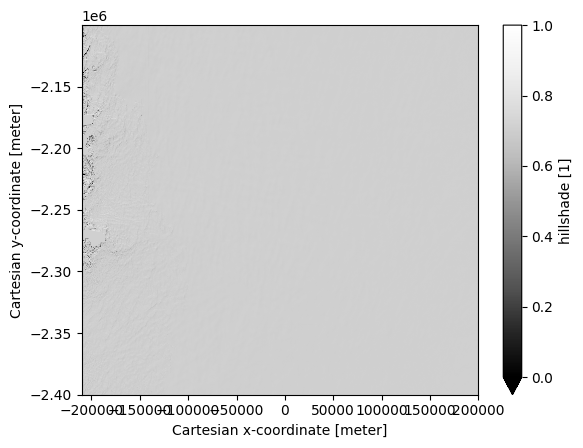

In [22]:
hs = hillshade(ds_dem["surface"], normalize=True)
hs.plot(cmap="Greys_r", vmin=0, vmax=1)

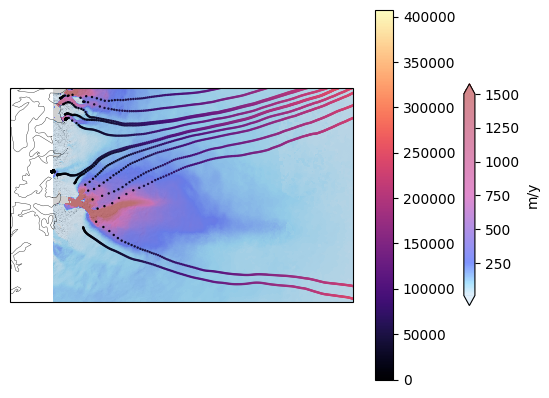

In [30]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
f = ds.sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))["v"].plot(vmin=10, vmax=1500, cmap=cmap, shading="flat", alpha=0.5,
                 transform=crs, 
             cbar_kwargs={"location": "right", "orientation": "vertical", 
                          "fraction": 0.085, "shrink": 0.6, "label": ds["v"].units},
             subplot_kws={"projection": crs}
)
hs.plot(cmap="Greys_r", vmin=0, vmax=1, ax=f.axes, zorder=-1, add_colorbar=False)
f.axes.coastlines(linewidth=0.25, resolution="10m")
t_l = result.plot(ax=f.axes, column="distance_from_origin", markersize=0.5, cmap="magma", legend=True)
f.axes.set_extent([-51, -44, 68.5, 70])

In [29]:
result.plot?

Signature:      result.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x17a199e50>
File:           ~/miniconda3/envs/pypism/lib/python3.12/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
kind: str
    The kind of plots to produce. The default is to create a map ("geo").
    Other supported kinds of plots from pandas:

    - 'line' : line plot
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : BoxPlot
    -

In [ ]:
h.where(h > 0, h, 0)

In [ ]:
h

In [ ]:
from matplotlib.colors import LightSource

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)

In [ ]:
plt.imshow(ls.blend_overlay(ds["v"].to_numpy(), ds_dem["surface"].to_numpy()))

In [ ]:
ls.blend_overlay?